# METHODOLOGY - EMOTION RECOGNITION

# Data

In [1]:
# tf 1.15 for capsnet
# cudnn 7.4, cuda = 10.0
# matplotlin, seaborn
# sklearn

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import numpy as np
import pandas as pd
from glob import glob

In [4]:
files = glob("../data/project_data/data_*_oversampled.csv")
print(files)
test_df = pd.read_csv(files[0])
train_df = pd.read_csv(files[1])
val_df = pd.read_csv(files[2])

['../data/project_data\\data_test_oversampled.csv', '../data/project_data\\data_train_oversampled.csv', '../data/project_data\\data_val_oversampled.csv']


In [5]:
r_train_x, r_train_y = train_df['text'], train_df['sentiment']
r_val_x, r_val_y = val_df['text'], val_df['sentiment']
r_test_x, r_test_y = test_df['text'], test_df['sentiment']
len(r_train_x)

33500

# Tokenization

In [6]:
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from math import ceil
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from matplotlib import pyplot as plt

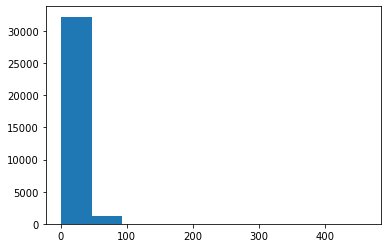

In [7]:
# see distribution
train_text_len = [len(i.split()) for i in r_train_x]
plt.hist(train_text_len)
plt.show()
# hellow word = len 2

In [8]:
# count words
def count_words(sentences):
    counts = {}
    for s in sentences:
        for word in s.split():
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

max_len = 65 # based from the word distribution above
max_features = len(count_words(r_train_x))
print("max_len",max_len,"max_features", max_features)

# tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(r_train_x)

# convert words to numbers
train_x = tokenizer.texts_to_sequences(r_train_x)
val_x = tokenizer.texts_to_sequences(r_val_x)
test_x = tokenizer.texts_to_sequences(r_test_x)

# pad sentences
# max_len = min(max_len, len(max(train_x, key=len)))
# [hellow world]  
# [1 2] max le = 5
# [1 2 0 0 0]
# [1 2 3 4 5]
train_x = sequence.pad_sequences(train_x, padding="pre",maxlen=max_len, truncating="post")
val_x = sequence.pad_sequences(val_x, padding="pre",maxlen=max_len, truncating="post")
test_x = sequence.pad_sequences(test_x, padding="pre",maxlen=max_len, truncating="post")

max_len 65 max_features 37187


In [9]:
# label binarizer : fear = 1, happy =2, ...
lb = LabelBinarizer()
lb.fit(r_train_y)

# use inverse_transform to get the original class names
train_y = lb.transform(r_train_y)
val_y = lb.transform(r_val_y)
test_y = lb.transform(r_test_y)


In [10]:
for i in range(10):
    print(f"label '{r_test_y[i]}' :: encoding {test_y[i]}")

label 'Fear' :: encoding [0 1 0 0 0]
label 'Fear' :: encoding [0 1 0 0 0]
label 'Angry' :: encoding [1 0 0 0 0]
label 'Surprise' :: encoding [0 0 0 0 1]
label 'Fear' :: encoding [0 1 0 0 0]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Surprise' :: encoding [0 0 0 0 1]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Happy' :: encoding [0 0 1 0 0]
label 'Fear' :: encoding [0 1 0 0 0]


# embeddings


In [11]:
%%time
# emb_file = "../data/glove.6B.100d.txt"
# emb_size = 100 # glove 100d
# emb_file = "../data/glove.twitter.27B.50d.txt"
# emb_size = 50


# get the word embeddings
emb_file = "../data/glove.twitter.27B.100d.txt" # <- 
# emb_file = "../data/glove.twitter.27B.50d.txt" # <- 80-82% test acc
# emb_file = "../data/glove.twitter.27B.25d.txt" # <- 76 %
emb_size = 100 #50 #100


Wall time: 0 ns


In [12]:
def extract_emb(emb_file):
    # extract the embedding data
    embeddings_index = {}
    f = open(emb_file, encoding="utf8") 
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
        
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index
    
def get_embedding_matrix(emb_file, emb_size):
    embeddings_index = extract_emb(emb_file)

    # get the embedding matrix
    word_index = tokenizer.word_index
    nb_words = max_features #min(max_features, len(word_index))

    # do we nee to add plus 1 in nb_words?
    embedding_matrix = np.zeros((nb_words, emb_size)) 

    for word, i in word_index.items():
        if i >= nb_words: continue # disregard first
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Model

In [13]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import *

# hyper parameter tuning
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
# study how attenion layer works
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias':self.bias
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [15]:


# F1
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > 0.35).astype(int)
            score = f1_score(self.y_val, y_pred, average="micro")
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

def get_predict_metrics(pred, test_y):
    # classification report
    pred_y = np.argmax(pred, axis=1)
    true_y = np.argmax(test_y, axis=1)
    print(classification_report(true_y, pred_y))

    # visualize confusion matrix
    
    mlt_cm = multilabel_confusion_matrix(true_y, pred_y)
    labels = ["".join("c" + str(i)) for i in range(0, 6)]
    fig, ax = plt.subplots(5, 1, figsize=(12, 20))
    for axes, cfs_matrix, label in zip(ax.flatten(), mlt_cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()    
    
    
# model plot
def make_plot(loss, val_loss, acc, val_acc):
    t = np.arange(1,len(loss)+1,1)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    plt.subplots_adjust(wspace=0.2)

    ax1.plot(t, loss)
    ax1.plot(t, val_loss)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Train vs Val loss')
    ax1.legend(['train','val'], ncol=2, loc='upper right')

    ax2.plot(t, acc)
    ax2.plot(t, val_acc)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('Train vs Val acc')
    ax2.legend(['train','val'], ncol=2, loc='upper right')

    plt.show();

## MODELS

In [16]:

def BiGRUAttenGPU(input_dropout = 0.25, inter_dropout = 0.25,spatial_dropout = True, gru_units=[64], dense_units=[32], 
                  has_flatten=False, mask_zero = False, has_capsule=[]):
    
    # input layers
    inp = Input(shape=(max_len, ))
    
    # embedding layers
    x = Embedding(max_features,emb_size,weights=[embedding_matrix],trainable=False, mask_zero=mask_zero)(inp)# mask_zero is to ignore the zero paddings
    
    # dropout layer
    if input_dropout != 1: # if 1 = no dropout
        if spatial_dropout:
            x = SpatialDropout1D(input_dropout)(x)

        else:
            x = Dropout(input_dropout)(x)
            
    # BiGRU layer
    for gru_unit in gru_units:
        x = Bidirectional(GRU(gru_unit, return_sequences=True, activation='tanh', recurrent_activation = 'sigmoid', recurrent_dropout=0, unroll=False, use_bias=True, reset_after =True))(x) # setup for GPU GRU
    
    # attention layer
    x = Attention(max_len)(x)
    x = Dropout(inter_dropout)(x)
    
    # capsule layer
    if len(has_capsule) != 0: # capsule should be list containing the three param below
        x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)
        x = Flatten()(x)
        
    # conv layer
#     for cnn_unit in cnn_units:
#         x = Conv1D()
    
    # dense layer
    for dense_unit in dense_units:
        x = Dense(dense_unit, activation="relu")(x) # 256
        if inter_dropout != 1: # if 1 = no dropout
            x = Dropout(inter_dropout)(x)
    
    # flatten layer
    if has_flatten:
        x = Flatten()(x)
    
    # classification layer
    x = Dense(5, activation="softmax")(x)
    
    # build model
    model = Model(inputs=inp, outputs=x, name='BiGRUAttenGPU')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model



without dropout = 80% for 100d word embedding

In [17]:
# from tqdm import tqdm,trange
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


## Neural Network - Brute Force Search

In [18]:
emb_size = 100
emb_file = "../data/glove.twitter.27B.100d.txt"
embedding_matrix = get_embedding_matrix(emb_file, emb_size)

Found 1193514 word vectors.


In [19]:
from tqdm import tqdm

trainig_start
MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [24] : [12] : False : 0.2 : 0.2
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           3718700   
_________________________________________________________________
dropout (Dropout)            (None, 65, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 48)            18144     
_________________________________________________________________
attention (Attention)        (None, 48)                113       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0        

131/131 [==============================] - 2s 12ms/step - loss: 0.9334 - acc: 0.6605 - val_loss: 0.8471 - val_acc: 0.6857
Epoch 49/300
131/131 [==============================] - 2s 12ms/step - loss: 0.9368 - acc: 0.6569 - val_loss: 0.8352 - val_acc: 0.6921
Epoch 50/300
131/131 [==============================] - 2s 12ms/step - loss: 0.9253 - acc: 0.6603 - val_loss: 0.8372 - val_acc: 0.6967
Epoch 51/300
131/131 [==============================] - 2s 13ms/step - loss: 0.9232 - acc: 0.6633 - val_loss: 0.8359 - val_acc: 0.6888
Epoch 52/300
131/131 [==============================] - 2s 14ms/step - loss: 0.9299 - acc: 0.6603 - val_loss: 0.8426 - val_acc: 0.6900
Epoch 53/300
131/131 [==============================] - 2s 13ms/step - loss: 0.9241 - acc: 0.6627 - val_loss: 0.8359 - val_acc: 0.6933
Epoch 54/300
131/131 [==============================] - 2s 12ms/step - loss: 0.9240 - acc: 0.6627 - val_loss: 0.8283 - val_acc: 0.6926
Epoch 55/300
131/131 [==============================] - 2s 13ms/step

Epoch 109/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8658 - acc: 0.6856 - val_loss: 0.7871 - val_acc: 0.7022
Epoch 110/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8553 - acc: 0.6878 - val_loss: 0.7886 - val_acc: 0.7050
Epoch 111/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8552 - acc: 0.6904 - val_loss: 0.7986 - val_acc: 0.6986
Epoch 112/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8588 - acc: 0.6881 - val_loss: 0.7940 - val_acc: 0.7019
Epoch 113/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8603 - acc: 0.6908 - val_loss: 0.8103 - val_acc: 0.6969
Epoch 114/300
131/131 [==============================] - 2s 12ms/step - loss: 0.8570 - acc: 0.6917 - val_loss: 0.8010 - val_acc: 0.7029
Epoch 115/300
131/131 [==============================] - 2s 13ms/step - loss: 0.8494 - acc: 0.6921 - val_loss: 0.7999 - val_acc: 0.7038
Epoch 116/300
131/131 [=========================

131/131 [==============================] - 2s 15ms/step - loss: 0.8343 - acc: 0.6957 - val_loss: 0.7922 - val_acc: 0.6988
Epoch 170/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8242 - acc: 0.7021 - val_loss: 0.7767 - val_acc: 0.7103
Epoch 171/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8240 - acc: 0.7021 - val_loss: 0.7876 - val_acc: 0.7005
Epoch 172/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8280 - acc: 0.7001 - val_loss: 0.7725 - val_acc: 0.7079
Epoch 173/300
131/131 [==============================] - 2s 18ms/step - loss: 0.8238 - acc: 0.7027 - val_loss: 0.7798 - val_acc: 0.7072
Epoch 174/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8314 - acc: 0.6993 - val_loss: 0.7949 - val_acc: 0.7055
Epoch 175/300
131/131 [==============================] - 2s 16ms/step - loss: 0.8289 - acc: 0.7024 - val_loss: 0.8025 - val_acc: 0.6988
Epoch 176/300
131/131 [==============================] - 2s 15

131/131 [==============================] - 2s 17ms/step - loss: 0.8059 - acc: 0.7091 - val_loss: 0.7773 - val_acc: 0.7096
Epoch 230/300
131/131 [==============================] - 2s 18ms/step - loss: 0.8083 - acc: 0.7080 - val_loss: 0.7677 - val_acc: 0.7153
Epoch 231/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8123 - acc: 0.7053 - val_loss: 0.7776 - val_acc: 0.7081
Epoch 232/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8095 - acc: 0.7084 - val_loss: 0.7894 - val_acc: 0.7041
Epoch 233/300
131/131 [==============================] - 2s 16ms/step - loss: 0.8160 - acc: 0.7065 - val_loss: 0.7786 - val_acc: 0.7127
Epoch 234/300
131/131 [==============================] - 2s 17ms/step - loss: 0.8125 - acc: 0.7067 - val_loss: 0.7636 - val_acc: 0.7191
Epoch 235/300
131/131 [==============================] - 2s 16ms/step - loss: 0.8112 - acc: 0.7076 - val_loss: 0.7810 - val_acc: 0.7067
Epoch 236/300
131/131 [==============================] - 2s 15

Epoch 289/300
131/131 [==============================] - 2s 16ms/step - loss: 0.7985 - acc: 0.7148 - val_loss: 0.7881 - val_acc: 0.7048
Epoch 290/300
131/131 [==============================] - 2s 15ms/step - loss: 0.8035 - acc: 0.7102 - val_loss: 0.7713 - val_acc: 0.7146
Epoch 291/300
131/131 [==============================] - 2s 16ms/step - loss: 0.8001 - acc: 0.7105 - val_loss: 0.7764 - val_acc: 0.7084
Epoch 292/300
131/131 [==============================] - 2s 17ms/step - loss: 0.8072 - acc: 0.7079 - val_loss: 0.7743 - val_acc: 0.7148
Epoch 293/300
131/131 [==============================] - 2s 17ms/step - loss: 0.8049 - acc: 0.7102 - val_loss: 0.7810 - val_acc: 0.7129
Epoch 294/300
131/131 [==============================] - 2s 17ms/step - loss: 0.7965 - acc: 0.7120 - val_loss: 0.7983 - val_acc: 0.7024
Epoch 295/300
131/131 [==============================] - 2s 17ms/step - loss: 0.8002 - acc: 0.7113 - val_loss: 0.7757 - val_acc: 0.7141
Epoch 296/300
131/131 [=========================

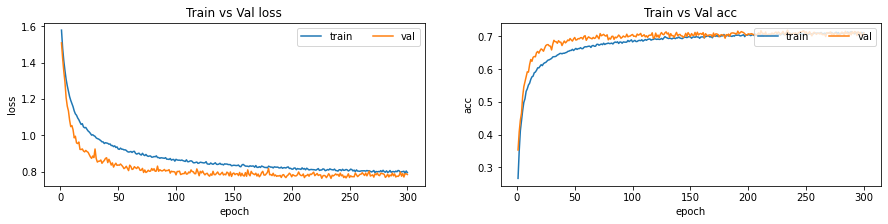

TEST PREDICTION
              precision    recall  f1-score   support

           0       0.58      0.74      0.65       386
           1       0.74      0.63      0.68      1050
           2       0.63      0.79      0.70       563
           3       0.73      0.70      0.72      1072
           4       0.78      0.74      0.76      1116

    accuracy                           0.71      4187
   macro avg       0.69      0.72      0.70      4187
weighted avg       0.72      0.71      0.71      4187



In [24]:
# %%time
"""
at 64 gru unit its already overfitting

32 gru + 16 dense,== 32 gru + 32 dense => 72% with good fit
"""


#  hyperparameters
# gru_units = [[16], [32], [64]]# [16,16], [32,32]]
# dense_units = [[8], [16], [32]]# [8,8], [16,16]]
# spatial_dropout = [False] #[True, False]
# input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
# inter_dropout = [0.2]#[0.2, 0.3, 0.5, 0.7, 0.9, 1]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance

# gru_units = [[16,16], [32,32]]
# dense_units = [[16], [32]]# [8,8], [16,16]]
# spatial_dropout = [False] #[True, False]
# input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
# inter_dropout = [0.2]#[0.2, 0.3, 0.5, 0.7, 0.9, 1]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance

# gru_units = [[32]]
# dense_units = [[16]]#[[16], [32]]# [8,8], [16,16]]
# spatial_dropout = [False] #[True, False]
# input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
# inter_dropout = [0.2]#

gru_units = [[24]]
dense_units = [[12]]#[[16], [32]]# [8,8], [16,16]]
spatial_dropout = [False] #[True, False]
input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
inter_dropout = [0.2]#

# 16 : 16 = 71 slightly over fit
# 24 :16 = 71 good fit


# save scores
model_hist = []
eval_score = []
loss_score = []
emb_model_ls = {}
model_param_info = {}
# Train on 16729 samples, validate on 2091 samples
epochs = 300 # 300 # 1000 # 60 is usually where it starts to overlap

# hyper parameter tuning loop, since keras-tuner is having a problem with the dependencies
# emb_file = ["../data/glove.twitter.27B.25d.txt","../data/glove.twitter.27B.50d.txt"]
# emb_size = [25, 50]
print("trainig_start")

# for emb_size, embedding_matrix in zip(emb_size_ls, embedding_matrix_ls): # [1] = 100D, [0] = 50D
for batch_size in [256]: # 256 best performance
    for gu in gru_units:
        for du in dense_units:
            for sd in spatial_dropout:
                for inpd in input_dropout:
                    for intd in inter_dropout:
                        print("================================================================")
                        print("================================================================")
                        print("MODEL START")
                        print(f"emb_size : batch_size : gu : du : sd : inpd : intd")
                        print(f"{emb_size} : {batch_size} : {gu} : {du} : {sd} : {inpd} : {intd}")
                        K.clear_session()
                        # TRAINING
                    #     model = BiGRUAttenGPU(mask_zero = True, spatial_dropout = False, gru_units=64) # 80
                    #     model = BiGRUAtten()
                    #     model = BiGRUAttenGPU(mask_zero = False, spatial_dropout = False, gru_units=64, has_capsule=True) # 81
                    #     model = RathnayakaModel()
                    #     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
                        model = BiGRUAttenGPU(input_dropout = inpd, inter_dropout = intd, spatial_dropout = sd, gru_units=gu, dense_units=du, has_flatten=False, mask_zero = False) # 81
                        model.summary()
                        hist = model.fit(x=train_x, y=train_y, epochs=epochs, batch_size=batch_size, 
                                         validation_data=(val_x,val_y))#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed
                        model_hist.append((model, hist)) # save model and history

                        print("EVALUATION")
                        # this one doesnt have the saved model yet, uses the last 
                        _, train_acc = model.evaluate(train_x, train_y, verbose=0)
                        _, val_acc = model.evaluate(val_x, val_y, verbose=0)
                        _, test_acc = model.evaluate(test_x, test_y, verbose=0)
                        print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))
                        eval_score.append( (train_acc,val_acc,test_acc) ) # save model eval score
                        # FITTING PLOT
                        val_loss = hist.history['val_loss'];val_acc = hist.history['val_acc']
                        loss = hist.history['loss'];acc = hist.history['acc']
                        make_plot(loss, val_loss, acc, val_acc)
                        loss_score.append( (loss, val_loss, acc, val_acc) )# save model loss scor
                        # PREDICTION
                        print("TEST PREDICTION")
                        pred = model.predict(test_x, verbose=0)
#                             get_predict_metrics(pred, test_y)
                        # print(cls_report)
                        pred_y = np.argmax(pred, axis=1)
                        true_y = np.argmax(test_y, axis=1)
                        print(classification_report(true_y, pred_y))

                        model_param_info.update({"param": (gu,du,sd,inpd,intd), 
                                                 "model": model_hist,
                                                 "eval": eval_score,
                                                 "loss": loss_score})
                    

emb_model_ls.update({f"{emb_size}-Dim":model_param_info})
    
    

In [ ]:
label 'Fear' :: encoding [0 1 0 0 0]
label 'Angry' :: encoding [1 0 0 0 0]
label 'Surprise' :: encoding [0 0 0 0 1]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Happy' :: encoding [0 0 1 0 0]

In [21]:
"""
# BEST PARAM
{'word_emb': '50D',
 'parameter': ([16], [16], False, 0.2)}
 
{'word_emb': '25D',
 'parameter': ([16], [8], False, 0.3, 0.5)}
"""
# emb_model_ls
# 1st Dim = word emb
# 2nd Dim = model, acc, history
# 3rd Dim = training
# num_train = len(emb_model_ls['50-Dim'][0])
best_NN_model = {}
test_acc = 0

for dim in emb_model_ls:
    for j in range(len(num_train[dim]['param'])): # number of distinct model based from hyper parameter tuning
        # accuracy metric reject - get best test acc by taking the mean of the val acc test
        # new_test_acc = emb_model_ls[dim]['eval'][j][-1]
        # new_test_acc = sum(new_test_acc)/len(new_test_acc) 
        
        new_test_acc = emb_model_ls[dim]['eval'][j][-1] # -1 because last index is test accuracy
        
        if new_test_acc > test_acc:
            test_acc = new_test_acc
            best_emb = dim
            best_param = emb_model_ls[dim]['param']
            best_model = emb_model_ls[dim]['model']
            best_acc = emb_model_ls[dim]['eval']
            best_hist = emb_model_ls[dim]['loss']
    
    # save best param per word dimension
    best_NN_model.update({f"best_{dim}":{
                            "word_emb": dim,
                            "parameter": best_param,
                            "model": best_model,
                            "accuracies": best_acc,
                            "history": best_hist }})
# save best param overall
best_NN_model.update({"best_overall":{
                        "word_emb": dim,
                        "parameter": best_param,
                        "model": best_model,
                        "accuracies": best_acc,
                        "history": best_hist }})

best_NN_model
        

NameError: name 'num_train' is not defined

In [ ]:
def get_best_parameter(best_model):
    
    b_gu = best_model['parameter'][0]
    b_du = best_model['parameter'][1]
    b_sd = best_model['parameter'][2]
    b_inp = best_model['parameter'][3]
    b_itr = best_model['parameter'][4]
    print("=====================")
    print("      PARAMETERS      ")
    print("=====================")
    print(f"Word Embedding Dim : {best_model['word_emb']}")
    print(f"GRU Units          : {b_gu}")
    print(f"Dense Units        : {b_du}") 
    print(f"Spatial Dropout    : {b_sd}")
    print(f"Dropout Val (Input): {b_inp}")
    print(f"Dropout Val (Inter): {b_itr}")
    print("=====================")
    print("_________________________________________________________________")

    print("=====================")
    print("        MODEL")
    print("=====================")
    b_model = best_model['model'][0]
    b_model.summary()
    b_loss = best_model['history'][0]
    b_val_loss = best_NN_model['history'][1]
    b_acc = best_model['history'][2]
    b_val_acc = best_model['history'][3]
    make_plot(b_loss, b_val_loss, b_acc, b_val_acc)
    print("_________________________________________________________________")

    print("=====================")
    print("     EVALUATION")
    print("=====================")
    train_acc = best_model['accuracies'][0]
    val_acc = best_model['accuracies'][1]
    test_acc = best_model['accuracies'][2]
    print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

    print("_________________________________________________________________")
    print("=====================")
    print("   TEST PREDICTION   ")
    print("=====================")
    b_pred = b_model.predict(test_x, verbose=0)
    get_predict_metrics(b_pred, test_y)
    
for key in best_NN_model:
    print("\n\n")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(f"Best Models : {key}")
    get_best_parameter(best_NN_model[key])
    
    
    
    

In [ ]:
"""
# BEST PARAM
{'word_emb': '50D',
 'parameter': ([16], [16], False, 0.2)}
 
{'word_emb': '25D',
 'parameter': ([16], [8], False, 0.3, 0.5)}
"""
# emb_model_ls
# 1st Dim = word emb
# 2nd Dim = model, acc, history
# 3rd Dim = trainings
num_train = len(emb_model_ls[0][0])
best_NN_model = {}
test_acc = 0
for i in range(len(emb_size_ls)): # word embedding
    if i == 0 : best_emb = "25D"
    if i == 1 : best_emb = "50D"
    if i == 2 : best_emb = "100D"
    
    for j in range(num_train):
        
        # better accuracy metric
        nn_acc = emb_model_ls[i][1][j][1] # accuracy rates list
        new_test_acc = nn_acc[-1] # -1 because last index is test accuracy
        
        # accuracy metric reject - get best test acc by taking the mean of the val acc test
        # nn_hist_test = emb_model_ls[i][2][j][1][-1]
        # new_test_acc = sum(nn_hist_test)/len(nn_hist_test)
        
        # update best parameter
        if new_test_acc > test_acc:
            test_acc = new_test_acc
            best_param, best_acc = emb_model_ls[i][1][j]
            best_model = emb_model_ls[i][0][j][1]
            best_hist = emb_model_ls[i][2][j][1]
        else:
            test_acc = test_acc
            best_param = best_param
            best_acc = best_acc
            best_model = best_model
            best_hist = best_hist
            
best_NN_model.update({"word_emb":best_emb,
                      "parameter":best_param,
                      "accuracies":best_acc,
                      "model":best_model,
                      "history":best_hist})
best_NN_model

In [ ]:
b_gu = best_NN_model['parameter'][0]
b_du = best_NN_model['parameter'][1]
b_sd = best_NN_model['parameter'][2]
b_inp = best_NN_model['parameter'][3]
b_itr = best_NN_model['parameter'][4]
print("=====================")
print("      PARAMETERS      ")
print("=====================")
print(f"Word Embedding Dim : {best_NN_model['word_emb']}")
print(f"GRU Units          : {b_gu}")
print(f"Dense Units        : {b_du}") 
print(f"Spatial Dropout    : {b_sd}")
print(f"Dropout Val (Input): {b_inp}")
print(f"Dropout Val (Inter): {b_itr}")
print("=====================")
print("_________________________________________________________________")

print("=====================")
print("        MODEL")
print("=====================")
b_model = best_NN_model['model'][0]
b_model.summary()
b_loss = best_NN_model['history'][0]
b_val_loss = best_NN_model['history'][1]
b_acc = best_NN_model['history'][2]
b_val_acc = best_NN_model['history'][3]
make_plot(b_loss, b_val_loss, b_acc, b_val_acc)
print("_________________________________________________________________")

print("=====================")
print("     EVALUATION")
print("=====================")
_, train_acc = b_model.evaluate(train_x, train_y, verbose=0)
_, val_acc = b_model.evaluate(val_x, val_y, verbose=0)
_, test_acc = b_model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

print("_________________________________________________________________")
print("=====================")
print("   TEST PREDICTION   ")
print("=====================")
b_pred = b_model.predict(test_x, verbose=0)
get_predict_metrics(b_pred, test_y)

on epoch = 50, batch size = 256
dtaa = 80:10:10, 12k data
test acc
25d = 76 %
50d = 82 %
100d = 

In [ ]:
# for when we apllied checkpoint saving
"""
# load the saved model../data/sentiment_NLP/model_train/_weights_.{epoch:02d}-{val_acc:.2f}.hdf5
saved_model = tf.keras.models.load_model('../data/sentiment_NLP/model_train/BiGRUAtten/_weights_.41-0.82.hdf5')
# saved_model = load_model('../data/sentiment_NLP/model_train/BiGRUAtten/_weights_.79-0.82.hdf5')
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
"""

#
test different word embedding dimensions

kohen kappa? for confusion matrix

# Hyper Parameter tuning

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters as hp
import pickle
import time
import os

In [ ]:
int(time.time())

In [ ]:
def BiGRUAtten_modelHP(hp):
    # hyper parameters
    gru_units = hp.Int("gru_units", min_value=64, max_value=256, step=32)
    dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=32)
    drop_out = hp.Float("dropout_val", min_value=0.25, max_value=0.5, step=0.125)
    drop_out_type = hp.Boolean("dropout_type")
    dense_layers = hp.Int("dense_layers", 1, 2)
    has_flatten = hp.Boolean("has_flatten_layer")
    
    
    # start model
    
    inp = Input(shape=(max_len, ))

    x = Embedding(max_features, emb_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # set embedding dropout
    x = Dropout(drop_out)(x) if drop_out_type == False else SpatialDropout1D(drop_out)(x)
    
    # setup to activate GPU GRU
#     x = Bidirectional(GRU(gru_units, return_sequences=True))
    x = Bidirectional(GRU(gru_units, return_sequences=True, activation='tanh', recurrent_activation = 'sigmoid',
                         recurrent_dropout=0, unroll=False, use_bias=True, reset_after =True))(x)
    x = Attention(max_len)(x)
    
    # number of dense layers after the GRU + atten layers
    for i in range(dense_layers):
        x = Dense(dense_units, activation="relu")(x)
        x = Dropout(drop_out)(x)

    if has_flatten:
        x = Flatten()(x)
    
    x = Dense(3, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x, name='BiGRUAtten')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
            
    

In [ ]:
os.path.normpath(f'C:/{int(time.time())}')

In [ ]:
# param_grid = dict(mask_zero=mask_zero,spatial_dropout=spatial_dropout,drop_out_val=drop_out_val,
#                  gru_units=gru_units,dense_layers=dense_layers, batch_size=[128, 256], epochs=[50])

# ps = PredefinedSplit(test_fold=your_test_fold) # when we already have predefined valid/test set
# grif = GridSearchCV(estimator = model, param_grid=para_grid, cv=5)

# model = BiGRUAtten_modelling()
# model.fit(train_x, train_y, batch_size=256, epochs= 50, validation=(val_x, val_y))

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


LOG_DIR = os.path.normpath(f'C:/{int(time.time())}')

# tuning setup
tuner = RandomSearch(
    BiGRUAtten_modelHP,
    objective = "val_accuracy",
    max_trials = 450, # 1,
    executions_per_trial = 1,
    directory = LOG_DIR
#     directory = f"../data/{int(time.time())}"
)
tuner.search(x=train_x,
            y=train_y,
            epochs=50,
            batch_size=256,
            validation_data=(val_x, val_y)#(val_x,val_y),
            )

# save best model
with open(f"../data/model_tuning/model_tuner_test_as_tuner.pkl", "wb") as f:
    pickle.dump(tuner, f)







In [ ]:
# import best tuner
tuner = pickle.load(open(f"../data/model_tuning/model_tuner_test_as_tuner.pkl", "rb"))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())
print(tuner.get_best_models()[0].summary()) # get the tensorflow model

# Training

In [ ]:
model = tuner.get_best_models()[0]
model.summary()
print("Start Training")
hist = model.fit(x=train_x, y=train_y, epochs=50, batch_size=256, validation_data=(val_x,val_y))#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed
# hist = model.fit(x=train_x, y=train_y, epochs=50, batch_size=256, validation_data=(test_x,test_y))#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed

print("EVALUATION")
# this one doesnt have the saved model yet, uses the last 
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, val_acc = model.evaluate(val_x, val_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
# _, val_acc = model.evaluate(test_x, test_y, verbose=0)
# _, test_acc = model.evaluate(val_x, val_y, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

# FITTING
val_loss = hist.history['val_loss'];val_acc = hist.history['val_accuracy']
loss = hist.history['loss'];acc = hist.history['accuracy']
make_plot(loss, val_loss, acc, val_acc)

# PREDICTION
print("TEST PREDICTION")
# pred = model.predict(val_x, verbose=0)
# get_predict_metrics(pred, val_y)
pred = model.predict(test_x, verbose=0)
get_predict_metrics(pred, test_y)
# print(cls_report)